<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Module 1:</span> Data Wrangling</h1>
<hr>

Welcome to <span style="color:royalblue">Module 1: Data Wrangling</span>!

Often, the most interesting machine learning applications require you to **wrangle** your data first.

For this project, we've been given a **transaction-level** dataset. In other words, each observation in the raw dataset is for a single transaction - one item, one customer, one purchase.

Therefore, to get a **customer-level** data (since we want to build clusters for customers, not transactions) we need to **aggregate transactions by customer** and **engineer customer-level features**.

* This step blends together exploratory analysis, data cleaning, and feature engineering.
* Here, feature engineering comes from aggregating the transaction-level data.
* As you'll see, you still have a lot of room for creativity in this step!

<br><hr id="toc">

### In this module...

In this module, we'll cover:
1. [Transaction-level exploration](#exploration)
2. [Transaction-level cleaning](#cleaning)
3. [Customer-level feature engineering](#customer-level)
4. [Intermediary levels](#intermediary-levels)
5. [Joining together the ABT](#joining)


<br><hr>

### First, let's import libraries and load the dataset.

First, import libraries that you'll need.

In [1]:
# print_function for compatibility with Python 3
from __future__ import print_function

# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns


Next, let's import the dataset.
* The file path is <code style="color:crimson">'project_files/int_online_tx.csv'</code>

In [2]:
# Load international online transactions data from CSV
df = pd.read_csv('project_files/int_online_tx.csv')

Now we're ready to jump into wrangling the data!

<span id="exploration"></span>
# 1. Transaction-level exploration

Even though we eventually want customer-level data, it's still helpful to do some basic exploratory analysis at the transaction level. 

<br>
**First, display the shape of the dataset.**

In [3]:
# Dataframe dimensions
df.shape

(35116, 8)

**Next, display the first 10 observations from the dataset.**

In [4]:
# First 10 rows of data
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


**Finally, display the distribution of transactions by country.**

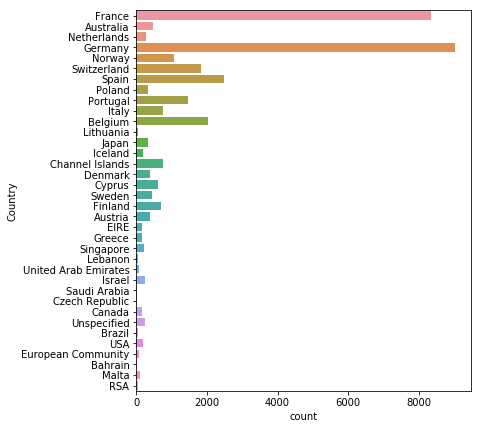

In [14]:
# Make figsize 6x7
plt.figure(figsize=(6,7))

# Bar plot by country
sns.countplot(y='Country', data=df)

<div style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</div>

<span id="cleaning"></span>
# 2. Transaction-level cleaning

Before we aggregate to the customer level, we need to tidy up a few things at the transaction level.

<br>
**Display the number of missing observations for each feature.**

In [6]:
# Missing data by feature
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

**Drop observations with missing customer ID's.**

In [7]:
# Only keep transactions with CustomerID's
df = df[df.CustomerID.notnull()]

**Next, just for clarity, convert the CustomerID's from floats into integers.**
* This is technically not required, but it's good practice.
* ID's should be saved as strings or integers just so they don't get mixed up with other numeric features.
* Then, display the first 5 CustomerID's in the transaction dataset just to confirm.

In [8]:
# Convert customer ID's into integers
df.CustomerID = df.CustomerID.astype(int)

# Display first 5 CustomerID's in the transaction dataset
df.CustomerID.head()


0    12583
1    12583
2    12583
3    12583
4    12583
Name: CustomerID, dtype: int64

**Create a <code style="color:steelblue">'Sales'</code> interaction feature.**
* Then, display the first 5 Sales values in the transaction dataset just to confirm.

In [9]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

# Display first 5 Sales values in the transaction dataset
df.Sales.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

**Before moving on, save your cleaned transaction-level data as <code style="color:crimson">cleaned_transactions.csv</code>.**
* We'll return to this in <span style="color:royalblue">Modules 2 and 3</span> to create the features for individual items.
* Remember to set <code style="color:steelblue">index=None</code> to save only the data and not the auto-generated index.

In [10]:
# Save cleaned transaction-level data
df.to_csv('cleaned_transactions', index=None)

<div style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</div>

<span id="customer-level"></span>
# 3. Customer-level feature engineering

Now that we have a cleaned transaction-level dataset, it's time to **roll it up** to the customer level, which we'll feed into our machine learning algorithms later.

<br>
**First, we'll aggegrate invoice data by customer. We'll engineer 1 feature:**
* <code style="color:steelblue">'total_transactions'</code> - the total number of unique transactions for each customer.

In [16]:
# Aggegrate invoice data
invoice_data = df.groupby('CustomerID').InvoiceNo.agg({ 'total_transactions' : 'nunique' })

# Display invoice data for first 5 customers
invoice_data.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


**Next, using the same technique, aggregate product data by customer. Engineer 2 features:**
* <code style="color:steelblue">'total_products'</code> - the total number of products purchased by each customer (not the unit Quantity within each product!).
* <code style="color:steelblue">'total_unique_products'</code> - the number of unique products purchased by each customer.
* **Hint:** you'll want to use the Item ID column (i.e. StockCode) after your groupby!
* Let's name it <code style="color:crimson">product_data</code>.

In [30]:
# Aggregate product data
product_data = df.groupby('CustomerID').StockCode.agg({'total_products' : 'count',
                                          'total_unique_products' : 'nunique'})

# Display product data for first 5 customers
product_data.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


**Finally, aggregate sales data by customer. Engineer 2 features:**
* <code style="color:steelblue">'total_sales'</code> - the total sales for each customer.
* <code style="color:steelblue">'avg_product_value'</code> - the average value of the products purchased by the customer (not the UnitPrice!).
* **Hint:** you'll want to use the Sales column after your groupby!
* Let's name it <code style="color:crimson">sales_data</code>.

In [33]:
# Roll up sales data
sales_data = df.groupby('CustomerID').Sales.agg({'avg_product_value' : 'mean',
                                                 'total_sales' : 'sum'})

# Display sales data for first 5 customers
sales_data.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,avg_product_value,total_sales
CustomerID,,
12347,23.681319,4310.00
12348,57.975484,1797.24
12349,24.076027,1757.55
12350,19.670588,334.40
12352,29.482824,2506.04


<div style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</div>

<span id="intermediary-levels"></span>
# 4. Intermediary levels

You won't always be able to easily roll up to customer-level directly... Sometimes, it will be easier to create intermediary levels first.

<br>
**Let's first aggregate cart data at the "cart-level."**
* We'll group by <code style="color:steelblue">'CustomerID'</code> AND by <code style="color:steelblue">'InvoiceID'</code>. Remember, we're treating each invoice as a "cart."
* Then, we'll calculate <code style="color:steelblue">'cart_value'</code> by taking the sum of the Sales column. This is the total sales by invoice (i.e. cart).
* Finally, we'll call <code style="color:steelblue">.reset_index()</code> to turn CustomerID and InvoiceID back into regular columns so we can perform another aggregation.

In [35]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID', 'InvoiceNo']).Sales.agg({'cart_value' : 'sum'})

# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 5 CARTS
cart_data.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91


**Aggregate cart data by customer. Engineer 3 features:**
* <code style="color:steelblue">'avg_cart_value'</code> - average cart value by customer.
* <code style="color:steelblue">'min_cart_value'</code> - minimum cart value by customer.
* <code style="color:steelblue">'max_cart_value'</code> - maximum cart value by customer.
* Let's name it <code style="color:crimson">agg_cart_data</code>.

In [41]:
# Aggregate cart data (at customer-level)
agg_cart_data = df.groupby('CustomerID').Sales.agg({'min_cart_value' : 'min',
                                                 'max_cart_value' : 'max',
                                                 'avg_cart_value' : 'mean'})


# Display cart data for first 5 CUSTOMERS
agg_cart_data.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


,min_cart_value,max_cart_value,avg_cart_value
CustomerID,,,
12347,5.04,249.6,23.681319
12348,13.20,240.0,57.975484
12349,6.64,300.0,24.076027
12350,8.50,40.0,19.670588
12352,9.90,376.5,29.482824


<div style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</div>

<span id="joining"></span>
# 5. Joining together the ABT

Great, now you have multiple dataframes that each contain customer-level features. 

<br>
**Let's join the various customer-level datasets together with the <code style="color:steelblue">.join()</code> function.**
* Just pick one of the customer-level dataframes and join it to a list of the others.
* By default, it will join the dataframes on their <code style="color:steelblue">index</code>... In this case, it will join by CustomerID, which is exactly what we want.
* You can read more about the <code style="color:steelblue">.join()</code> function in the <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html" target="_blank">documentation</a>.

In [42]:
# Join together customer-level ABT
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])

# Display customer-level data for first 5 customers
customer_df.head()

,total_transactions,total_products,total_unique_products,avg_product_value,total_sales,min_cart_value,max_cart_value,avg_cart_value
CustomerID,,,,,,,,
12347,7,182,103,23.681319,4310.00,5.04,249.6,23.681319
12348,4,31,22,57.975484,1797.24,13.20,240.0,57.975484
12349,1,73,73,24.076027,1757.55,6.64,300.0,24.076027
12350,1,17,17,19.670588,334.40,8.50,40.0,19.670588
12352,8,85,59,29.482824,2506.04,9.90,376.5,29.482824


**Finally, let's save <code style="color:crimson">customer_df</code> as our analytical base table to use later.**
* **Important:** We will not set <code style="color:steelblue">index=None</code> because we want to keep the CustomerID's as the index (this will be important when we get to Module 4).

In [43]:
# Save analytical base table
customer_df.to_csv('analytical_base_table.csv')

<div style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</div>

<br>
## Next Steps

Congratulations for making it through Project 4's Data Wrangling!

As a reminder, here are a few things you did in this module:
* You explored and cleaned the transaction-level dataset.
* You then rolled it up to the customer level, aggregating new features along the way.
* You also saw how intermediary groupby's can help you create otherwise tricky features.
* And you joined all of your customer-level datasets together into one analytical base table.

In the next module, <span style="color:royalblue">Module 2: Dimensionality Reduction</span>, we'll see how trying to include features for individual items can raise new challenges (i.e. The Curse of Dimensionality). We'll also introduce you to the first of 2 recommended solutions: thresholding.

<div style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</div>